In [1]:
%matplotlib notebook
from utils.dataloader import PascalVOCDataset
from utils.dataloader import myimshow
import torch
import torch.utils.data as td
import torchvision as tv
import numpy as np
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"

#Creating training and validation sets. Go to utils/dataloader.py for info on important PascalVOCDataset arguments & attributes
train_set = PascalVOCDataset(dataset_root_dir, mode= 'train')
val_set = PascalVOCDataset(dataset_root_dir, mode= 'val')

#Create dataloaders
B = 50
train_loader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True)
val_loader = td.DataLoader(val_set, batch_size = B, pin_memory = True)

<IPython.core.display.Javascript object>


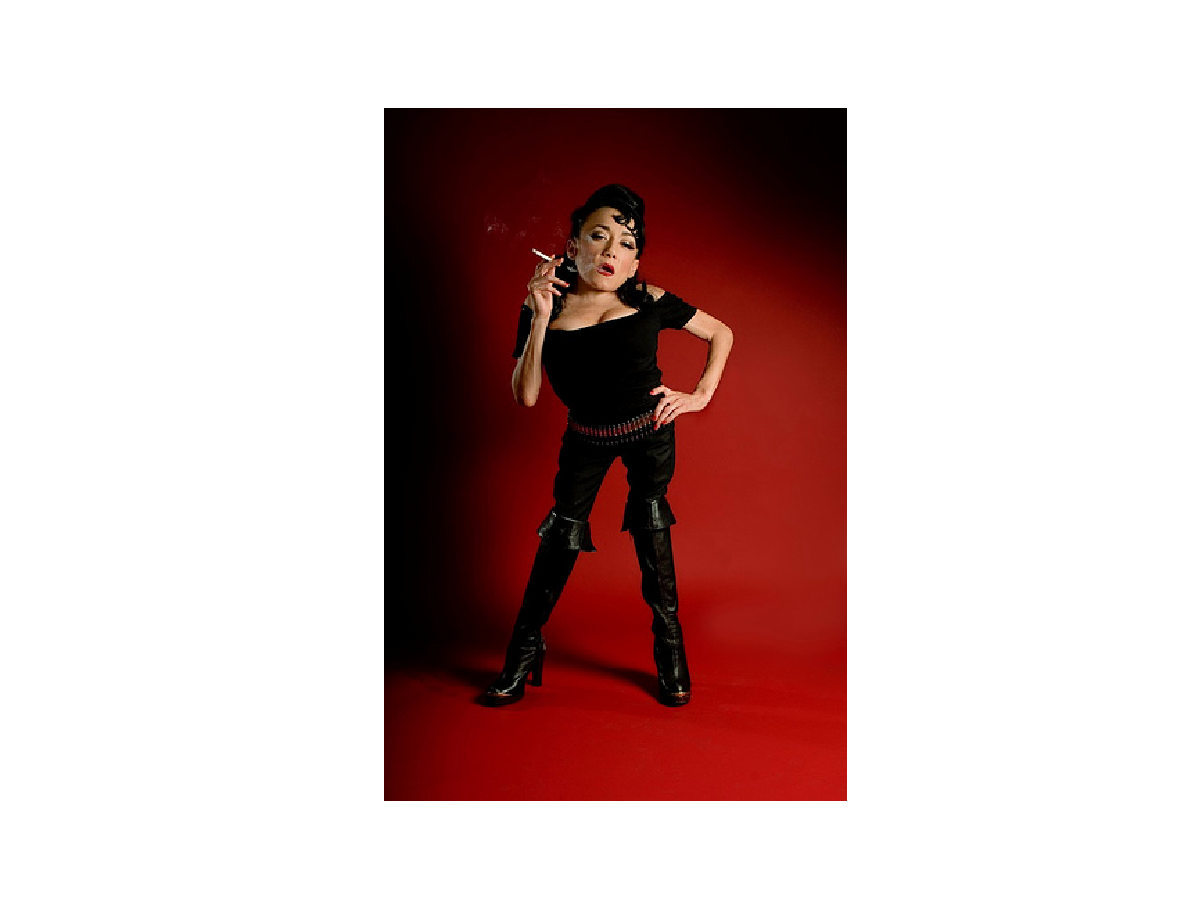

Bounding box corners [72, 54, 253, 434]


In [3]:
#Training set image demo
fig, ax = plt.subplots()
x, mask, objects = train_set.__getitem__(50)
h = myimshow(x, ax)
for i in range(len(objects)):
    print("Bounding box corners", objects[i]['bbox'])